In [1]:
import wandb
from datasets import load_dataset, DownloadMode
import pyarrow as pa
import pyarrow.compute as compute
from datasets.arrow_dataset import Dataset

DATA_DIR = 'databricks/databricks-dolly-15k'
CACHE_DIR = '/NS/twitter-9/work/vnanda/invariances_in_reps/llm/data'

In [2]:
dataset = load_dataset(DATA_DIR, 
                       cache_dir=CACHE_DIR, 
                       revision='b122d1b59226377d51cb23bc16e9769e8ede491f')

Found cached dataset json (/NS/twitter-9/work/vnanda/invariances_in_reps/llm/data/databricks___json/databricks--databricks-dolly-15k-55ac4bf59abf58ea/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset['train'].config_name

'databricks--databricks-dolly-15k'

In [4]:
DATA_DIR.replace('/','--')

'databricks--databricks-dolly-15k'

In [5]:
dataset.keys()

dict_keys(['train'])

In [6]:
len(dataset['train']), type(dataset['train']), dir(dataset['train'])

(15014,
 datasets.arrow_dataset.Dataset,
 ['_TF_DATASET_REFS',
  '__class__',
  '__del__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__enter__',
  '__eq__',
  '__exit__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getitem__',
  '__getitems__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__iter__',
  '__le__',
  '__len__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_build_local_temp_path',
  '_check_index_is_initialized',
  '_data',
  '_estimate_nbytes',
  '_fingerprint',
  '_format_columns',
  '_format_kwargs',
  '_format_type',
  '_generate_examples_from_shards',
  '_get_cache_file_path',
  '_get_output_signature',
  '_getitem',
  '_indexes',
  '_indices',
  '_info',
  '_map_single',
  '_new_dataset_with_indices',
  '_output_all_columns',
  '_push_parquet_shards_to_hub',
  '_save_to_disk_s

In [7]:
dataset['train'].info

DatasetInfo(description='', citation='', homepage='', license='', features={'instruction': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'response': Value(dtype='string', id=None), 'category': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='json', config_name='databricks--databricks-dolly-15k', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=12326170, num_examples=15014, shard_lengths=None, dataset_name='json')}, download_checksums={'https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/b122d1b59226377d51cb23bc16e9769e8ede491f/databricks-dolly-15k.jsonl': {'num_bytes': 13216570, 'checksum': None}}, download_size=13216570, post_processing_size=None, dataset_size=12326170, size_in_bytes=25542740)

In [29]:
filtered_dataset = Dataset(
    dataset['train'].data.filter(dataset['train'].data['category'].to_numpy() == 'closed_qa'),
    info=dataset['train'].info)
len(filtered_dataset)

1823

In [32]:
(dataset['train'].data['category'].to_numpy() == 'closed_qa') | \
(dataset['train'].data['category'].to_numpy() == 'open_qa')

array([ True, False,  True, ...,  True, False, False])

In [30]:
filtered_dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'instruction': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'response': Value(dtype='string', id=None), 'category': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='json', config_name='databricks--databricks-dolly-15k', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=12326170, num_examples=15014, shard_lengths=None, dataset_name='json')}, download_checksums={'https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/b122d1b59226377d51cb23bc16e9769e8ede491f/databricks-dolly-15k.jsonl': {'num_bytes': 13216570, 'checksum': None}}, download_size=13216570, post_processing_size=None, dataset_size=12326170, size_in_bytes=25542740)

In [13]:
dataset.data['train'].column('category').unique()

[
  "closed_qa",
  "classification",
  "open_qa",
  "information_extraction",
  "brainstorming",
  "general_qa",
  "summarization",
  "creative_writing"
]

In [10]:
length_context_by_category = {}
length_instruction_by_category = {}
length_response_by_category = {}
num_by_category = {}

for idx, (inst, context, response, category) in enumerate(zip(
    dataset.data['train']['instruction'], dataset.data['train']['context'],
    dataset.data['train']['response'], dataset.data['train']['category'])):
#     if idx % 100 == 0:
    if 'einstein' in str(context).lower() or 'einstein' in str(response).lower():
        print (f'Context: {context}')
        print (f'Instruction: {inst}')
        print (f'Response: {response}')
        print (f'Category: {category}')
        print ()
        print ()
        print ()
    
    if str(category) not in num_by_category:
        num_by_category[str(category)] = 1
    else:
        num_by_category[str(category)] += 1
    
    if str(category) not in length_context_by_category:
        length_context_by_category[str(category)] = [len(str(context))]
        length_instruction_by_category[str(category)] = [len(str(inst))]
        length_response_by_category[str(category)] = [len(str(response))]
    else:
        length_context_by_category[str(category)].append(len(str(context)))
        length_instruction_by_category[str(category)].append(len(str(inst)))
        length_response_by_category[str(category)].append(len(str(response)))

Context: Albert Einstein (/ˈaɪnstaɪn/ EYEN-styne;[4] German: [ˈalbɛʁt ˈʔaɪnʃtaɪn] (listen); 14 March 1879 – 18 April 1955) was a German-born theoretical physicist,[5] widely acknowledged to be one of the greatest and most influential physicists of all time. Einstein is best known for developing the theory of relativity, but he also made important contributions to the development of the theory of quantum mechanics. Relativity and quantum mechanics are the two pillars of modern physics.[1][6] His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been dubbed "the world's most famous equation".[7] His work is also known for its influence on the philosophy of science.[8][9] He received the 1921 Nobel Prize in Physics "for his services to theoretical physics, and especially for his discovery of the law of the photoelectric effect",[10] a pivotal step in the development of quantum theory. His intellectual achievements and originality resulted in "Einstein" beco

In [7]:
length_context_by_category

{'closed_qa': [516,
  1194,
  815,
  662,
  1124,
  978,
  828,
  539,
  571,
  1318,
  514,
  1769,
  660,
  670,
  557,
  3600,
  582,
  1007,
  1034,
  646,
  760,
  398,
  703,
  844,
  414,
  1358,
  745,
  1115,
  618,
  905,
  771,
  464,
  370,
  813,
  1388,
  871,
  498,
  1470,
  1115,
  760,
  619,
  1812,
  573,
  703,
  622,
  857,
  1085,
  1255,
  540,
  1303,
  4466,
  3208,
  786,
  1626,
  528,
  551,
  2342,
  439,
  356,
  1124,
  514,
  643,
  1767,
  999,
  2142,
  664,
  838,
  1393,
  327,
  671,
  1181,
  307,
  985,
  1790,
  544,
  1691,
  315,
  359,
  1643,
  389,
  8851,
  491,
  165,
  2782,
  716,
  548,
  1165,
  676,
  779,
  772,
  4212,
  612,
  951,
  512,
  649,
  1077,
  824,
  1196,
  1421,
  1446,
  1209,
  963,
  283,
  335,
  465,
  4656,
  787,
  943,
  684,
  966,
  1091,
  410,
  1065,
  12672,
  432,
  425,
  986,
  754,
  1233,
  1328,
  691,
  735,
  445,
  477,
  1013,
  636,
  763,
  824,
  4807,
  965,
  721,
  1051,
  1262,
  263,
 

In [13]:
import sys
sys.path.append('..')
import plot_helper as plt_hp
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


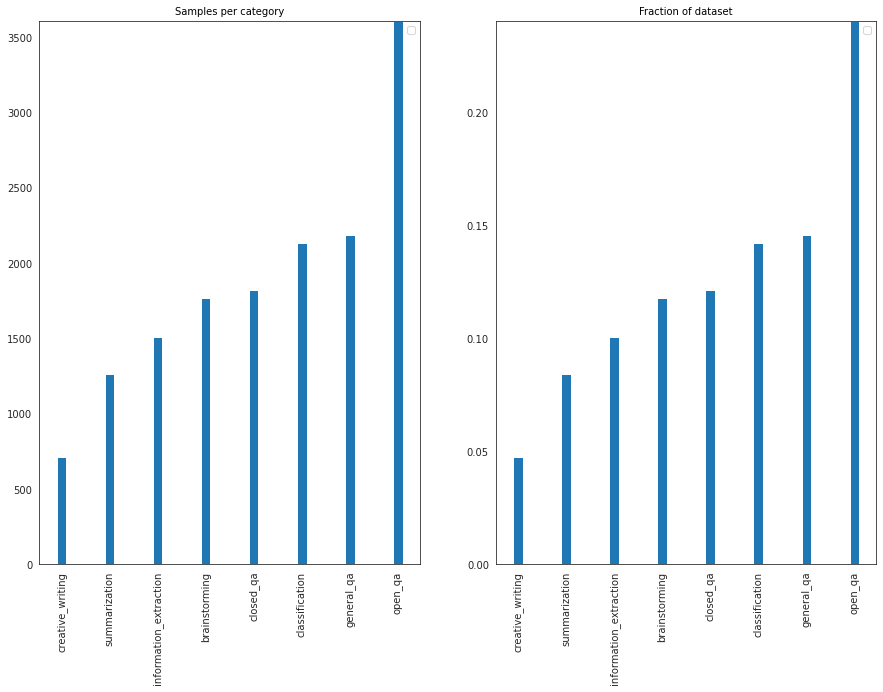

'results/dolly15k/samples_per_category.png'

In [19]:
category, count = list(zip(*sorted(num_by_category.items(), key=lambda x: x[1])))
plt_hp.stitched_bar(
    [[list(count)],[[x/sum(count) for x in count]]], 
    ['Samples per category', 'Fraction of dataset'], 
    'results/dolly15k', 'samples_per_category', 
    'png', [(0., max(count)), (0.,max([x/sum(count) for x in count]))], 
    [category]*2, legend_vals=None, 
    global_title='', columns=2, 
    savefig=True, plot_title_colors=None, figsize=(15,10))

In [31]:
category, length_context = list(zip(*sorted(
    length_context_by_category.items(), key=lambda x: x[0])))
avg_length_context = [sum(x)/len(x) for x in length_context]

_, length_instruction = list(zip(*sorted(
length_instruction_by_category.items(), key=lambda x: x[0])))
avg_length_instruction = [sum(x)/len(x) for x in length_instruction]

_, length_response = list(zip(*sorted(
length_response_by_category.items(), key=lambda x: x[0])))
avg_length_response = [sum(x)/len(x) for x in length_response]


avg_length_context, avg_length_instruction, avg_length_response

([0.0,
  0.0,
  1077.3252879868348,
  0.0,
  0.0,
  1207.3267195767196,
  0.0,
  1291.8606492478227],
 [60.71307300509338,
  123.15823970037454,
  73.1223258365332,
  89.66385372714487,
  74.04381560931081,
  74.85515873015873,
  45.68291332040986,
  56.229612034837686],
 [337.55517826825127,
  141.88436329588015,
  197.74876577070762,
  1001.4106891701829,
  581.4504792332268,
  307.9232804232804,
  288.5721406812517,
  496.83056215360256])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


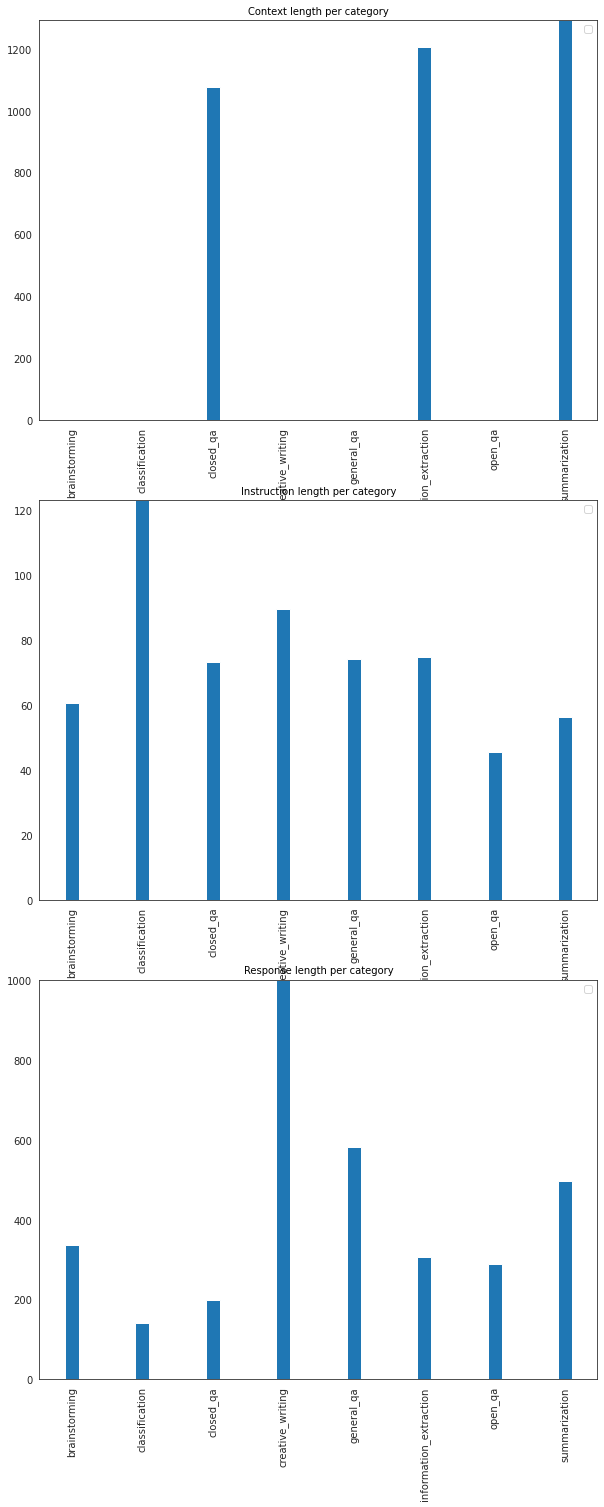

'results/dolly15k/instruction_and_context_length.png'

In [41]:
plt_hp.stitched_bar(
    [[avg_length_context], [avg_length_instruction], [avg_length_response]], 
    ['Context length per category','Instruction length per category', 'Response length per category'], 
    'results/dolly15k', 'instruction_and_context_length', 
    'png', [(0., max(avg_length_context)), (0.,max(avg_length_instruction)), (0.,max(avg_length_response))], 
    [category]*3, 
    legend_vals=None, 
    global_title='', columns=1, 
    savefig=True, plot_title_colors=None, figsize=(10,25))